In [1]:
import copy
import gzip
import io
import os
from io import StringIO
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import numpy as np
import pathlib
from pathlib import Path
from shapely import wkt
from datetime import datetime
import xml.etree.ElementTree as ET
import lxml.etree as etree
from xml.dom import minidom
import numpy as np

In [2]:
# read the files
BASE_DIR = Path.cwd().parent # G:\road_ntwrk
shp = BASE_DIR / "road_ntwrk" / "rd_ntwrk_2016.shp"
gpdSFRdNtwrk = gpd.read_file(shp)

In [3]:
gpdSFRdNtwrk=gpdSFRdNtwrk[gpdSFRdNtwrk['MTYPE']=='SF']

In [4]:
shp = BASE_DIR / "road_ntwrk" / "2016_PM.shp"
rd_network_2016 = gpd.read_file(shp)

In [5]:
rd_network_2016=rd_network_2016[rd_network_2016['FT'].isin([1,2,3,5,7,10])]

<AxesSubplot:>

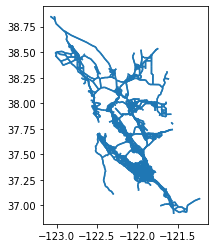

In [106]:
rd_network_2016[rd_network_2016['MTYPE']=='MTC'].plot()

In [6]:
outside_sf_fwy_arterial=rd_network_2016[rd_network_2016['MTYPE']=='MTC']
outside_sf_fwy_arterial.head()

,A,B,TOLL,USE,CAP,AT,FT,STREETNAME,TYPE,MTYPE,...,V11T_1,V12T_1,V13T_1,V14T_1,V15T_1,V16T_1,V17T_1,V18T_1,V19T_1,geometry
5911,4000,4006,0,1,1400,4,5,None,None,MTC,...,0,0,0.0,0,0,0,0,0,0,"LINESTRING (-122.21987 37.83293, -122.21403 37..."
5912,4000,4008,0,1,950,4,7,None,None,MTC,...,0,0,0.0,0,0,0,0,0,0,"LINESTRING (-122.21987 37.83293, -122.21412 37..."
5914,4001,4969,0,1,950,4,7,None,None,MTC,...,0,0,0.0,0,0,0,0,0,0,"LINESTRING (-121.91634 37.71698, -121.91928 37..."
5916,4001,13155,0,1,950,4,7,None,None,MTC,...,0,0,0.0,0,0,0,0,0,0,"LINESTRING (-121.91634 37.71698, -121.91304 37..."
5923,4004,4030,0,1,1950,4,2,None,None,MTC,...,0,0,0.0,0,0,0,0,0,0,"LINESTRING (-122.20904 37.82346, -122.20442 37..."


In [6]:
list(rd_network_2016)

['A',
 'B',
 'TOLL',
 'USE',
 'CAP',
 'AT',
 'FT',
 'STREETNAME',
 'TYPE',
 'MTYPE',
 'SPEED',
 'DISTANCE',
 'TIME',
 'LANE_AM',
 'LANE_OP',
 'LANE_PM',
 'BUSLANE_AM',
 'BUSLANE_OP',
 'BUSLANE_PM',
 'TOLLAM_DA',
 'TOLLAM_SR2',
 'TOLLAM_SR3',
 'TOLLPM_DA',
 'TOLLPM_SR2',
 'TOLLPM_SR3',
 'TOLLEA_DA',
 'TOLLEA_SR2',
 'TOLLEA_SR3',
 'TOLLMD_DA',
 'TOLLMD_SR2',
 'TOLLMD_SR3',
 'TOLLEV_DA',
 'TOLLEV_SR2',
 'TOLLEV_SR3',
 'VALUETOLL_',
 'PASSTHRU',
 'BUSTPS_AM',
 'BUSTPS_OP',
 'BUSTPS_PM',
 'TSVA',
 'TSIN',
 'BIKE_CLASS',
 'PER_RISE',
 'ONEWAY',
 'PROJ',
 'DTA_EDIT_F',
 'TOLLTIME',
 'PHASE',
 'ACTION',
 'AMBUSSAVE',
 'MDBUSSAVE',
 'PMBUSSAVE',
 'EVBUSSAVE',
 'EABUSSAVE',
 'SPDC',
 'CAPC',
 'AB',
 'BUSVOL_AM',
 'BUSVOL_MD',
 'BUSVOL_PM',
 'BUSVOL_EV',
 'BUSVOL_EA',
 'TIMESEED',
 'OOS',
 'PUDO',
 'V_1',
 'TIME_1',
 'VC_1',
 'CSPD_1',
 'VDT_1',
 'VHT_1',
 'V1_1',
 'V2_1',
 'V3_1',
 'V4_1',
 'V5_1',
 'V6_1',
 'V7_1',
 'V8_1',
 'V9_1',
 'V10_1',
 'V11_1',
 'V12_1',
 'V13_1',
 'V14_1',
 'V15_1',
 '

In [14]:
outside_sf_fwy_arterial.crs


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [15]:
gpdSFRdNtwrk.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [16]:
test=gpdSFRdNtwrk.append(outside_sf_fwy_arterial)

In [17]:
len(gpdSFRdNtwrk)

27000

In [18]:
len(outside_sf_fwy_arterial)

12881

In [19]:
len(test)

39881

<AxesSubplot:>

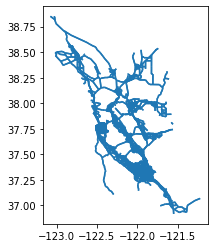

In [20]:
test.plot()

In [5]:
list(gpdSFRdNtwrk)

['A',
 'B',
 'TOLL',
 'USE',
 'CAP',
 'AT',
 'FT',
 'STREETNAME',
 'TYPE',
 'MTYPE',
 'SPEED',
 'DISTANCE',
 'TIME',
 'LANE_AM',
 'LANE_OP',
 'LANE_PM',
 'BUSLANE_AM',
 'BUSLANE_OP',
 'BUSLANE_PM',
 'TOLLAM_DA',
 'TOLLAM_SR2',
 'TOLLAM_SR3',
 'TOLLPM_DA',
 'TOLLPM_SR2',
 'TOLLPM_SR3',
 'TOLLEA_DA',
 'TOLLEA_SR2',
 'TOLLEA_SR3',
 'TOLLMD_DA',
 'TOLLMD_SR2',
 'TOLLMD_SR3',
 'TOLLEV_DA',
 'TOLLEV_SR2',
 'TOLLEV_SR3',
 'VALUETOLL_',
 'PASSTHRU',
 'BUSTPS_AM',
 'BUSTPS_OP',
 'BUSTPS_PM',
 'TSVA',
 'TSIN',
 'BIKE_CLASS',
 'PER_RISE',
 'ONEWAY',
 'PROJ',
 'DTA_EDIT_F',
 'TOLLTIME',
 'PHASE',
 'ACTION',
 'AMBUSSAVE',
 'MDBUSSAVE',
 'PMBUSSAVE',
 'EVBUSSAVE',
 'EABUSSAVE',
 'SPDC',
 'CAPC',
 'AB',
 'BUSVOL_AM',
 'BUSVOL_MD',
 'BUSVOL_PM',
 'BUSVOL_EV',
 'BUSVOL_EA',
 'TIMESEED',
 'OOS',
 'PUDO',
 'V_1',
 'TIME_1',
 'VC_1',
 'CSPD_1',
 'VDT_1',
 'VHT_1',
 'V1_1',
 'V2_1',
 'V3_1',
 'V4_1',
 'V5_1',
 'V6_1',
 'V7_1',
 'V8_1',
 'V9_1',
 'V10_1',
 'V11_1',
 'V12_1',
 'V13_1',
 'V14_1',
 'V15_1',
 '

In [50]:
gpdSFRdNtwrk = test


12881it [00:01, 6458.64it/s]


In [49]:
gpdSFRdNtwrk[gpdSFRdNtwrk['A']==22255]['first']

5911    POINT (548162.5634230318 4176254.918005444)
5912    POINT (548162.5634230318 4176254.918005444)
5913    POINT (548162.5634230318 4176254.918005444)
5914    POINT (548162.5634230318 4176254.918005444)
Name: first, dtype: object

In [30]:
gpdSFNode_A[gpdSFNode_A['first']==568648.6167971262]

,first,A
5912,568648.616797,22255


In [7]:
# read the files
# BASE_DIR = Path.cwd().parent # G:\road_ntwrk
# shp = BASE_DIR / "road_ntwrk" / "rd_ntwrk_2016.shp"

gpdSFRdNtwrk=gpdSFRdNtwrk.to_crs('EPSG:26910')
from shapely.geometry import Point, LineString
gpdSFRdNtwrk['first'] = None
gpdSFRdNtwrk['last'] = None
for index, row in tqdm(gpdSFRdNtwrk.iterrows()):
    coords = [(coords) for coords in list(row['geometry'].coords)]
    first_coord, last_coord = [ coords[i] for i in (0, -1) ]
    gpdSFRdNtwrk.at[index,'first'] = Point(first_coord)
    gpdSFRdNtwrk.at[index,'last'] = Point(last_coord)

gpdSFRdNtwrk["length_m"] = gpdSFRdNtwrk["geometry"].to_crs('EPSG:26910').length  # get length in meters of the feature
#gpdSFRdNtwrk["geometry"] = gpdSFRdNtwrk["geometry"].to_crs('EPSG:4326')  # re-project to EPSG:4326/WGS1984
#gpdSFRdNtwrk["geometry"] = gpdSFRdNtwrk["geometry"].to_crs('EPSG:26910') # re-project to local PCS

# get the max of the lanes
gpdSFRdNtwrk['lane']= gpdSFRdNtwrk[['LANE_AM','LANE_PM','LANE_OP',]].max(axis=1)

from shapely import wkt
gpdSFNode_A = gpdSFRdNtwrk[["first","A"]]
gpdSFNode_A = gpd.GeoDataFrame(gpdSFNode_A, geometry='first')

# gpdSFNode_A.drop_duplicates()
gpdSFNode_B = gpdSFRdNtwrk[["last","B"]]
gpdSFNode_B = gpd.GeoDataFrame(gpdSFNode_B, geometry='last')

G = gpdSFNode_A["first"].apply(lambda geom: geom.wkb) # drop duplicate features
gpdSFNode_A = gpdSFNode_A.loc[G.drop_duplicates().index]

G = gpdSFNode_B["last"].apply(lambda geom: geom.wkb) # drop duplicate features
gpdSFNode_B = gpdSFNode_B.loc[G.drop_duplicates().index]

gpdSFRdNtwrk["segment_id"] = gpdSFRdNtwrk[['A', 'B']].astype(str).agg('_'.join, axis=1)

gpdSFNode_A["X"] = gpdSFNode_A["first"].x
gpdSFNode_A["Y"] = gpdSFNode_A["first"].y

gpdSFNode_B["X"] = gpdSFNode_B["last"].x
gpdSFNode_B["Y"] = gpdSFNode_B["last"].y

26879it [00:03, 7733.92it/s]


In [8]:
# read the files
# BASE_DIR = Path.cwd().parent # G:\road_ntwrk
# shp = BASE_DIR / "road_ntwrk" / "rd_ntwrk_2016.shp"


outside_sf_fwy_arterial=outside_sf_fwy_arterial.to_crs('EPSG:26910')
from shapely.geometry import Point, LineString
outside_sf_fwy_arterial['first'] = None
outside_sf_fwy_arterial['last'] = None
for index, row in tqdm(outside_sf_fwy_arterial.iterrows()):
    coords = [(coords) for coords in list(row['geometry'].coords)]
    first_coord, last_coord = [ coords[i] for i in (0, -1) ]
    outside_sf_fwy_arterial.at[index,'first'] = Point(first_coord)
    outside_sf_fwy_arterial.at[index,'last'] = Point(last_coord)

outside_sf_fwy_arterial["length_m"] = outside_sf_fwy_arterial["geometry"].to_crs('EPSG:26910').length  # get length in meters of the feature
#gpdSFRdNtwrk["geometry"] = gpdSFRdNtwrk["geometry"].to_crs('EPSG:4326')  # re-project to EPSG:4326/WGS1984
#gpdSFRdNtwrk["geometry"] = gpdSFRdNtwrk["geometry"].to_crs('EPSG:26910') # re-project to local PCS

# get the max of the lanes
outside_sf_fwy_arterial['lane']= outside_sf_fwy_arterial[['LANE_AM','LANE_PM','LANE_OP',]].max(axis=1)

from shapely import wkt
outside_sf_fwy_arterial_Node_A = outside_sf_fwy_arterial[["first","A"]]
outside_sf_fwy_arterial_Node_A = gpd.GeoDataFrame(outside_sf_fwy_arterial_Node_A, geometry='first')

# gpdSFNode_A.drop_duplicates()
outside_sf_fwy_arterial_Node_B = outside_sf_fwy_arterial[["last","B"]]
outside_sf_fwy_arterial_Node_B = gpd.GeoDataFrame(outside_sf_fwy_arterial_Node_B, geometry='last')

G = outside_sf_fwy_arterial_Node_A["first"].apply(lambda geom: geom.wkb) # drop duplicate features
outside_sf_fwy_arterial_Node_A = outside_sf_fwy_arterial_Node_A.loc[G.drop_duplicates().index]

G = outside_sf_fwy_arterial_Node_B["last"].apply(lambda geom: geom.wkb) # drop duplicate features
outside_sf_fwy_arterial_Node_B = outside_sf_fwy_arterial_Node_B.loc[G.drop_duplicates().index]

outside_sf_fwy_arterial["segment_id"] = outside_sf_fwy_arterial[['A', 'B']].astype(str).agg('_'.join, axis=1)

outside_sf_fwy_arterial_Node_A["X"] = outside_sf_fwy_arterial_Node_A["first"].x
outside_sf_fwy_arterial_Node_A["Y"] = outside_sf_fwy_arterial_Node_A["first"].y

outside_sf_fwy_arterial_Node_B["X"] = outside_sf_fwy_arterial_Node_B["last"].x
outside_sf_fwy_arterial_Node_B["Y"] = outside_sf_fwy_arterial_Node_B["last"].y

14899it [00:01, 8418.88it/s]


In [9]:
outside_sf_fwy_arterial['FT']=np.where(outside_sf_fwy_arterial['FT']==7,
                                      25,
                                      outside_sf_fwy_arterial['FT'])

In [126]:
outside_sf_fwy_arterial.FT.value_counts()

25    9161
2     2651
5     2018
3      868
1      201
Name: FT, dtype: int64

In [10]:
# SF_shell_network=pd.merge(gpdSFRdNtwrk,outside_sf_fwy_arterial,
#                           how='outer',indicator=True)

SF_shell_network=gpdSFRdNtwrk.append(outside_sf_fwy_arterial)
len(SF_shell_network)

41778

In [115]:
SF_shell_network[SF_shell_network.duplicated(['A','B'])]

,A,B,TOLL,USE,CAP,AT,FT,STREETNAME,TYPE,MTYPE,SPEED,DISTANCE,TIME,LANE_AM,LANE_OP,LANE_PM,BUSLANE_AM,BUSLANE_OP,BUSLANE_PM,TOLLAM_DA,TOLLAM_SR2,TOLLAM_SR3,TOLLPM_DA,TOLLPM_SR2,TOLLPM_SR3,TOLLEA_DA,TOLLEA_SR2,TOLLEA_SR3,TOLLMD_DA,TOLLMD_SR2,TOLLMD_SR3,TOLLEV_DA,TOLLEV_SR2,TOLLEV_SR3,VALUETOLL_,PASSTHRU,BUSTPS_AM,BUSTPS_OP,BUSTPS_PM,TSVA,TSIN,BIKE_CLASS,PER_RISE,ONEWAY,PROJ,DTA_EDIT_F,TOLLTIME,PHASE,ACTION,AMBUSSAVE,MDBUSSAVE,PMBUSSAVE,EVBUSSAVE,EABUSSAVE,SPDC,CAPC,AB,BUSVOL_AM,BUSVOL_MD,BUSVOL_PM,BUSVOL_EV,BUSVOL_EA,TIMESEED,OOS,PUDO,V_1,TIME_1,VC_1,CSPD_1,VDT_1,VHT_1,V1_1,V2_1,V3_1,V4_1,V5_1,V6_1,V7_1,V8_1,V9_1,V10_1,V11_1,V12_1,V13_1,V14_1,V15_1,V16_1,V17_1,V18_1,V19_1,VT_1,V1T_1,V2T_1,V3T_1,V4T_1,V5T_1,V6T_1,V7T_1,V8T_1,V9T_1,V10T_1,V11T_1,V12T_1,V13T_1,V14T_1,V15T_1,V16T_1,V17T_1,V18T_1,V19T_1,geometry,first,last,length_m,lane,segment_id


In [11]:
def ffs(df):
    if df.FT==1:
        return df.SPEED/1.3
    elif df.FT==2:
        return df.SPEED/1.0
    elif df.FT==3:
        return df.SPEED/1.0
    elif df.FT==4:
        return df.SPEED/1.8
    elif df.FT==5:
        return df.SPEED/1.3
    elif df.FT==6:
        return df.SPEED/1.0
    elif df.FT==7:
        return df.SPEED/1.8
    elif df.FT==8:
        return df.SPEED/1.3
    elif df.FT==9:
        return df.SPEED/1.8
    elif df.FT==10:
        return df.SPEED/1.0
    elif df.FT==11:
        return df.SPEED/1.8
    elif df.FT==12:
        return df.SPEED/1.8
    elif df.FT==13:
        return df.SPEED/1.0
    elif df.FT==14:
        return df.SPEED/1.8
    else:
        return df.SPEED/1.8
    

In [136]:
gpdSFRdNtwrk['FFS']=gpdSFRdNtwrk.apply(ffs,axis=1)
gpdSFRdNtwrk.head()

,A,B,TOLL,USE,CAP,AT,FT,STREETNAME,TYPE,MTYPE,SPEED,DISTANCE,TIME,LANE_AM,LANE_OP,LANE_PM,BUSLANE_AM,BUSLANE_OP,BUSLANE_PM,TOLLAM_DA,TOLLAM_SR2,TOLLAM_SR3,TOLLPM_DA,TOLLPM_SR2,TOLLPM_SR3,TOLLEA_DA,TOLLEA_SR2,TOLLEA_SR3,TOLLMD_DA,TOLLMD_SR2,TOLLMD_SR3,TOLLEV_DA,TOLLEV_SR2,TOLLEV_SR3,VALUETOLL_,PASSTHRU,BUSTPS_AM,BUSTPS_OP,BUSTPS_PM,TSVA,TSIN,BIKE_CLASS,PER_RISE,ONEWAY,PROJ,DTA_EDIT_F,TOLLTIME,PHASE,ACTION,AMBUSSAVE,MDBUSSAVE,PMBUSSAVE,EVBUSSAVE,EABUSSAVE,SPDC,CAPC,AB,BUSVOL_AM,BUSVOL_MD,BUSVOL_PM,BUSVOL_EV,BUSVOL_EA,TIMESEED,OOS,PUDO,V_1,TIME_1,VC_1,CSPD_1,VDT_1,VHT_1,V1_1,V2_1,V3_1,V4_1,V5_1,V6_1,V7_1,V8_1,V9_1,V10_1,V11_1,V12_1,V13_1,V14_1,V15_1,V16_1,V17_1,V18_1,V19_1,VT_1,V1T_1,V2T_1,V3T_1,V4T_1,V5T_1,V6T_1,V7T_1,V8T_1,V9T_1,V10T_1,V11T_1,V12T_1,V13T_1,V14T_1,V15T_1,V16T_1,V17T_1,V18T_1,V19T_1,geometry,first,last,length_m,lane,segment_id,FFS
0,6956,40003,0,1,1400,4,5,HWY 101 N OFF-RAMP to HARNEY WY,None,MTC,35,0.1104,0.18926,1,1,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.00,F,0,0.0000,0,None,0,0.0,0,None,0,0,0,0,0,0,0,None,0.0,0.0,0.0,0.00,0.0,0.24631,0.0,0.0,1234.98926,0.24631,0.88214,26.89312,136.34282,5.06980,817.85638,99.35614,39.13331,0,0,0,0,0,0,185.76227,0,0,0.0,0,0,0,0,0,0,1234.98926,817.85638,99.35614,39.13331,0,0,0,0,0,0,185.76227,0,0,0.0,0,0,0,0,0,0,"LINESTRING (553350.000 4173346.000, 553476.580...",POINT (553349.9998151767 4173345.99985298),POINT (553476.5804237572 4173467.860898331),175.706474,1,6956_40003,26.923077
1,6956,40029,0,1,1900,3,2,HWY 101 NORTHBOUND,None,SF,60,0.1532,0.15320,4,4,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.29,F,0,0.0325,1,None,0,0.0,0,None,0,0,0,0,0,0,0,6956 40029,6.0,13.0,15.0,8.50,0.0,0.27996,0.0,0.0,22486.62500,0.27834,2.95877,33.02388,3444.95117,104.31697,13771.51855,1210.20850,441.41989,0,0,0,0,0,0,4688.98633,0,0,0.0,0,0,0,0,0,0,22486.62500,13771.51855,1210.20850,441.41989,0,0,0,0,0,0,4688.98633,0,0,0.0,0,0,0,0,0,0,"LINESTRING (553350.000 4173346.000, 553320.939...",POINT (553349.9998151767 4173345.99985298),POINT (553320.9392015886 4173588.026848777),243.765432,4,6956_40029,60.000000
2,6980,6994,0,1,1950,4,2,None,None,MTC,65,1.1100,1.02462,4,4,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.00,F,0,0.0000,0,None,0,0.0,0,None,0,0,0,0,0,0,0,6980 6994,10.5,13.0,6.0,11.33,0.0,1.48241,0.0,0.0,20656.09570,1.47944,2.64822,45.01689,22928.26563,509.32587,10982.23242,1346.01318,646.57666,0,0,0,0,0,0,5112.84912,0,0,0.0,0,0,0,0,0,0,20656.09570,10982.23242,1346.01318,646.57666,0,0,0,0,0,0,5112.84912,0,0,0.0,0,0,0,0,0,0,"LINESTRING (553257.000 4173404.000, 553426.000...",POINT (553256.9998158853 4173403.999854542),POINT (553425.9998170413 4171749.999855693),1662.611499,4,6980_6994,65.000000
3,6985,6980,0,1,1400,4,5,HWY 101 S ON-RAMP from BEATTY AVE,None,MTC,35,0.2193,0.37594,1,1,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.00,F,0,0.0000,0,None,0,0.0,0,None,0,0,0,0,0,0,0,None,0.0,0.0,0.0,0.00,0.0,0.48890,0.0,0.0,1007.16339,0.48890,0.71940,26.91331,220.87093,8.20675,487.67972,116.29843,57.07824,0,0,0,0,0,0,230.73799,0,0,0.0,0,0,0,0,0,0,1007.16339,487.67972,116.29843,57.07824,0,0,0,0,0,0,230.73799,0,0,0.0,0,0,0,0,0,0,"LINESTRING (553233.881 4173488.425, 553257.000...",POINT (553233.8811223421 4173488.425002129),POINT (553256.9998158853 4173403.999854542),87.533305,1,6985_6980,26.923077
4,6985,6986,0,1,800,4,4,BEATTY,AVE,MTC,30,0.2829,0.56580,1,1,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.00,F,0,-0.0039,0,None,0,0.0,0,None,0,0,0,0,0,0,0,None,0.0,0.0,0.0,0.00,0.0,1.01844,0.0,0.0,0.00000,1.01844,0.00000,16.66667,0.00000,0.00000,0.00000,0.00000,0.00000,0,0,0,0,0,0,0.00000,0,0,0.0,0,0,0,0,0,0,707.93414,339.29440,88.49213,46.63617,0,0,0,0,0,0,155.67430,0,0,0.0,0,0,0,0,0,0,"LINESTRING (553233.881 4173488.425, 552787.180...",POINT (553233.8811223421 4173488.425002129),POINT (552787.1804085139 4173442.741105828),449.030674,1,6985_

In [12]:

SF_shell_network['FFS']=SF_shell_network.apply(ffs,axis=1)
SF_shell_network.head()

,A,B,TOLL,USE,CAP,AT,FT,STREETNAME,TYPE,MTYPE,...,V17T_1,V18T_1,V19T_1,geometry,first,last,length_m,lane,segment_id,FFS
1,6956,40029,0,1,1900,3,2,HWY 101 NORTHBOUND,None,SF,...,0,0,0,"LINESTRING (553350.000 4173346.000, 553320.939...",POINT (553349.9998151767 4173345.99985298),POINT (553320.9392015886 4173588.026848777),243.765432,4,6956_40029,60.000000
5,6985,52492,0,1,700,3,4,ALANA,WY,SF,...,0,0,0,"LINESTRING (553233.881 4173488.425, 553212.903...",POINT (553233.8811223421 4173488.425002129),POINT (553212.9026749724 4173654.024205313),166.922711,1,6985_52492,16.666667
7,6986,50856,0,1,700,3,4,TUNNEL,AVE,SF,...,0,0,0,"LINESTRING (552787.180 4173442.741, 552770.941...",POINT (552787.1804085139 4173442.741105828),POINT (552770.9408277512 4173628.436435152),186.404075,1,6986_50856,16.666667
16,7678,51171,0,1,1450,3,3,SKYLINE,BLVD,SF,...,0,0,0,"LINESTRING (544554.000 4172455.000, 544230.238...",POINT (544553.9998171227 4172454.999854094),POINT (544230.2376741003 4173547.972607859),1139.917263,2,7678_51171,60.000000
17,7702,52234,0,1,1400,2,5,I-280 S ON-RAMP,None,SF,...,0,0,0,"LINESTRING (546770.000 4173201.000, 546735.344...",POINT (546769.9998163021 4173200.999854235),POINT (546735.3437780952 4173441.028341393),242.517454,1,7702_52234,23.076923


In [137]:
gpdSFRdNtwrk=gpdSFRdNtwrk.reset_index()
gpdSFRdNtwrk['LINK_ID']=gpdSFRdNtwrk.index+1
gpdSFRdNtwrk.drop(columns=['index'],inplace=True)

In [13]:
SF_shell_network=SF_shell_network.reset_index()
SF_shell_network['LINK_ID']=SF_shell_network.index+1
SF_shell_network.drop(columns=['index'],inplace=True)
SF_shell_network.head()

,A,B,TOLL,USE,CAP,AT,FT,STREETNAME,TYPE,MTYPE,...,V18T_1,V19T_1,geometry,first,last,length_m,lane,segment_id,FFS,LINK_ID
0,6956,40029,0,1,1900,3,2,HWY 101 NORTHBOUND,None,SF,...,0,0,"LINESTRING (553350.000 4173346.000, 553320.939...",POINT (553349.9998151767 4173345.99985298),POINT (553320.9392015886 4173588.026848777),243.765432,4,6956_40029,60.000000,1
1,6985,52492,0,1,700,3,4,ALANA,WY,SF,...,0,0,"LINESTRING (553233.881 4173488.425, 553212.903...",POINT (553233.8811223421 4173488.425002129),POINT (553212.9026749724 4173654.024205313),166.922711,1,6985_52492,16.666667,2
2,6986,50856,0,1,700,3,4,TUNNEL,AVE,SF,...,0,0,"LINESTRING (552787.180 4173442.741, 552770.941...",POINT (552787.1804085139 4173442.741105828),POINT (552770.9408277512 4173628.436435152),186.404075,1,6986_50856,16.666667,3
3,7678,51171,0,1,1450,3,3,SKYLINE,BLVD,SF,...,0,0,"LINESTRING (544554.000 4172455.000, 544230.238...",POINT (544553.9998171227 4172454.999854094),POINT (544230.2376741003 4173547.972607859),1139.917263,2,7678_51171,60.000000,4
4,7702,52234,0,1,1400,2,5,I-280 S ON-RAMP,None,SF,...,0,0,"LINESTRING (546770.000 4173201.000, 546735.344...",POINT (546769.9998163021 4173200.999854235),POINT (546735.3437780952 4173441.028341393),242.517454,1,7702_52234,23.076923,5


In [11]:
list(gpdSFRdNtwrk)

['A',
 'B',
 'TOLL',
 'USE',
 'CAP',
 'AT',
 'FT',
 'STREETNAME',
 'TYPE',
 'MTYPE',
 'SPEED',
 'DISTANCE',
 'TIME',
 'LANE_AM',
 'LANE_OP',
 'LANE_PM',
 'BUSLANE_AM',
 'BUSLANE_OP',
 'BUSLANE_PM',
 'TOLLAM_DA',
 'TOLLAM_SR2',
 'TOLLAM_SR3',
 'TOLLPM_DA',
 'TOLLPM_SR2',
 'TOLLPM_SR3',
 'TOLLEA_DA',
 'TOLLEA_SR2',
 'TOLLEA_SR3',
 'TOLLMD_DA',
 'TOLLMD_SR2',
 'TOLLMD_SR3',
 'TOLLEV_DA',
 'TOLLEV_SR2',
 'TOLLEV_SR3',
 'VALUETOLL_',
 'PASSTHRU',
 'BUSTPS_AM',
 'BUSTPS_OP',
 'BUSTPS_PM',
 'TSVA',
 'TSIN',
 'BIKE_CLASS',
 'PER_RISE',
 'ONEWAY',
 'PROJ',
 'DTA_EDIT_F',
 'TOLLTIME',
 'PHASE',
 'ACTION',
 'AMBUSSAVE',
 'MDBUSSAVE',
 'PMBUSSAVE',
 'EVBUSSAVE',
 'EABUSSAVE',
 'SPDC',
 'CAPC',
 'AB',
 'BUSVOL_AM',
 'BUSVOL_MD',
 'BUSVOL_PM',
 'BUSVOL_EV',
 'BUSVOL_EA',
 'TIMESEED',
 'OOS',
 'PUDO',
 'V_1',
 'TIME_1',
 'VC_1',
 'CSPD_1',
 'VDT_1',
 'VHT_1',
 'V1_1',
 'V2_1',
 'V3_1',
 'V4_1',
 'V5_1',
 'V6_1',
 'V7_1',
 'V8_1',
 'V9_1',
 'V10_1',
 'V11_1',
 'V12_1',
 'V13_1',
 'V14_1',
 'V15_1',
 '

In [14]:
SF_shell_network.groupby('FT')['FFS'].describe()

,count,mean,std,min,25%,50%,75%,max
FT,,,,,,,,
1,214.0,33.051761,3.667112,26.923077,30.769231,30.769231,38.461538,38.461538
2,2733.0,61.522137,4.209812,50.000000,60.000000,65.000000,65.000000,65.000000
3,913.0,58.548740,2.543930,45.000000,55.000000,60.000000,60.000000,60.000000
4,4185.0,15.486526,1.704076,11.111111,13.888889,16.666667,16.666667,16.666667
5,2165.0,24.832119,2.176726,19.230769,23.076923,23.076923,26.923077,26.923077
7,2188.0,17.416971,2.167313,13.888889,16.666667,16.666667,19.444444,19.444444
9,583.0,12.145035,1.343916,11.111111,11.111111,11.111111,13.888889,13.888889
11,16912.0,16.178847,1.168488,11.111111,16.666667,16.666667,16.666667,16.666667
12,2046.0,17.128272,2.739825,13.888889,13.888889,19.444444,19.444444,19.444444


In [19]:
gpdSFRdNtwrk[gpdSFRdNtwrk['FT']==12]

,A,B,TOLL,USE,CAP,AT,FT,STREETNAME,TYPE,MTYPE,...,V18T_1,V19T_1,geometry,first,last,length_m,lane,segment_id,FFS,LINK_ID
55,20041,20056,0,1,800,3,12,INNES,AVE,SF,...,0,0,"LINESTRING (555338.233 4176030.112, 555171.367...",POINT (555338.2325606989 4176030.111785293),POINT (555171.3674824955 4176146.850773989),203.646620,2,20041_20056,19.444444,56
57,20041,51678,0,1,800,3,12,INNES,AVE,SF,...,0,0,"LINESTRING (555338.233 4176030.112, 555531.586...",POINT (555338.2325606989 4176030.111785293),POINT (555531.5863913893 4175953.765083765),207.881030,1,20041_51678,19.444444,58
67,20056,20041,0,1,800,3,12,INNES,AVE,SF,...,0,0,"LINESTRING (555171.367 4176146.851, 555338.233...",POINT (555171.3674824955 4176146.850773989),POINT (555338.2325606989 4176030.111785293),203.646620,2,20056_20041,19.444444,68
69,20056,20163,0,1,800,3,12,INNES,AVE,SF,...,0,0,"LINESTRING (555171.367 4176146.851, 555005.992...",POINT (555171.3674824955 4176146.850773989),POINT (555005.9915294213 4176263.416136448),202.328173,2,20056_20163,19.444444,70
346,20163,20056,0,1,800,3,12,INNES,AVE,SF,...,0,0,"LINESTRING (555005.992 4176263.416, 555171.367...",POINT (555005.9915294213 4176263.416136448),POINT (555171.3674824955 4176146.850773989),202.328173,2,20163_20056,19.444444,347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26863,52996,23579,0,1,750,2,12,MISSION ROCK,ST,SF,...,0,0,"LINESTRING (553898.728 4180829.800, 553746.378...",POINT (553898.7279938692 4180829.799769955),POINT (553746.3778388022 4180796.915549221),155.858724,2,52996_23579,19.444444,26864
26871,53004,52248,0,1,750,2,12,MARIPOSA,ST,SF,...,0,0,"LINESTRING (553498.647 4179814.456, 553508.897...",POINT (553498.6473527221 4179814.456199002),POINT (553508.8974529592 4179815.338460159),10.288000,2,53004_52248,19.444444,26872
26872,53004,52249,0,1,750,2,12,MARIPOSA,ST,SF,...,0,0,"LINESTRING (553498.647 4179814.456, 553448.311...",POINT (553498.6473527221 4179814.456199002),POINT (553448.3106500665 4179810.241618016),50.512833,2,53004_52249,19.444444,26873
26880,53011,52642,0,1,750,2,12,MISSION BAY SOUTH,BLVD,SF,...,0,0,"LINESTRING (553618.889 4180533.571, 553770.909...",POINT (553618.8891838365 4180533.570702762),POINT (553770.9091594834 4180545.598360641),152.495041,1,53011_52642,19.444444,26881


In [16]:
gpdSFRdNtwrk.groupby('FT')['SPEED'].describe()

,count,mean,std,min,25%,50%,75%,max
FT,,,,,,,,
1,13.0,38.076923,2.531848,35.0,35.0,40.0,40.0,40.0
2,93.0,54.086022,4.034244,50.0,50.0,55.0,55.0,65.0
3,45.0,56.555556,5.092577,45.0,55.0,60.0,60.0,60.0
4,4197.0,27.881820,3.065047,20.0,25.0,30.0,30.0,30.0
5,150.0,28.333333,2.568959,25.0,25.0,30.0,30.0,35.0
7,2190.0,31.353881,3.900940,25.0,30.0,30.0,35.0,35.0
9,583.0,21.861063,2.419049,20.0,20.0,20.0,25.0,25.0
11,16913.0,29.121977,2.103228,20.0,30.0,30.0,30.0,30.0
12,2046.0,30.830890,4.931684,25.0,25.0,35.0,35.0,35.0


In [139]:
gpdSFRdNtwrk=gpdSFRdNtwrk[gpdSFRdNtwrk['FT']!=0]


In [78]:
SF_shell_network=SF_shell_network[SF_shell_network['FT']!=0]

In [15]:
SF_shell_network.FT.value_counts()

11    16912
25     9161
4      4185
2      2733
7      2188
5      2165
12     2046
3       913
9       583
15      478
1       214
13      200
Name: FT, dtype: int64

In [21]:
SF_shell_network[SF_shell_network['LINK_ID']==21980]

,A,B,TOLL,USE,CAP,AT,FT,STREETNAME,TYPE,MTYPE,...,V18T_1,V19T_1,geometry,first,last,length_m,lane,segment_id,FFS,LINK_ID
21979,28038,27855,0,1,350,3,11,32ND,AVE,SF,...,0,0,"LINESTRING (544691.407 4181850.265, 544700.056...",POINT (544691.4072299937 4181850.2649808),POINT (544700.055737637 4181713.359154812),137.178722,1,28038_27855,16.666667,21980


In [19]:
gpdSFRdNtwrk.FT.value_counts()

11    16913
4      4197
7      2190
12     2046
9       583
15      478
13      200
5       150
2        93
0        92
3        45
1        13
Name: FT, dtype: int64

In [12]:
gpdSFRdNtwrk['FT']=np.where(gpdSFRdNtwrk['LINK_ID']==21980,
                           16,
                           gpdSFRdNtwrk['FT'])

<AxesSubplot:>

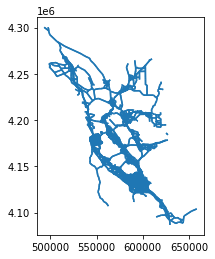

In [56]:
SF_shell_network.plot()

In [11]:
22.35/0.447

50.0

In [14]:
SF_shell_network.FT.value_counts()

11    16913
7     11351
4      4197
2      2744
12     2046
3       913
9       583
15      478
1       214
13      200
5       150
Name: FT, dtype: int64

In [140]:
node_A=gpdSFNode_A
node_B=gpdSFNode_B

In [145]:
node_B[node_B.duplicated(['B'])]

,last,B,X,Y


In [16]:
node_A=gpdSFNode_A.append(outside_sf_fwy_arterial_Node_A)
node_A=node_A.reset_index()
node_B=gpdSFNode_B.append(outside_sf_fwy_arterial_Node_B)
node_B=node_B.reset_index()

In [17]:
node_A.drop(columns=['index'],inplace=True)
node_B.drop(columns=['index'],inplace=True)
node_A.head()


,first,A,X,Y
0,POINT (553350.000 4173346.000),6956,553349.999815,4.173346e+06
1,POINT (553233.881 4173488.425),6985,553233.881122,4.173488e+06
2,POINT (552787.180 4173442.741),6986,552787.180409,4.173443e+06
3,POINT (544554.000 4172455.000),7678,544553.999817,4.172455e+06
4,POINT (546770.000 4173201.000),7702,546769.999816,4.173201e+06


In [18]:
node_A=node_A.drop_duplicates()
node_B=node_B.drop_duplicates()
node_A[node_A['A']==6956]

,first,A,X,Y
0,POINT (553350.000 4173346.000),6956,553349.999815,4.173346e+06


In [122]:
node_B[node_B['B']==6956]

,last,B,X,Y
12422,POINT (553350.000 4173346.000),6956,553349.999815,4.173346e+06


In [124]:
gpdSFRdNtwrk.MTYPE.value_counts()

SF    26879
Name: MTYPE, dtype: int64

In [125]:
SF_shell_network[SF_shell_network['MTYPE']=='MTC'].FT.value_counts()

25    9161
2     2651
5     2018
3      868
1      201
Name: FT, dtype: int64

In [84]:
SF_shell_network.FT.value_counts()

11.0    16913
4.0      4197
7.0      2190
12.0     2046
9.0       583
15.0      478
13.0      200
5.0       150
2.0        93
3.0        45
1.0        13
Name: FT, dtype: int64

In [19]:
pd.options.display.max_columns=120

In [20]:
SF_shell_network=SF_shell_network.drop_duplicates(['A','B'])

In [128]:
SF_shell_network[SF_shell_network['A']==40003]

,A,B,TOLL,USE,CAP,AT,FT,STREETNAME,TYPE,MTYPE,SPEED,DISTANCE,TIME,LANE_AM,LANE_OP,LANE_PM,BUSLANE_AM,BUSLANE_OP,BUSLANE_PM,TOLLAM_DA,TOLLAM_SR2,TOLLAM_SR3,TOLLPM_DA,TOLLPM_SR2,TOLLPM_SR3,TOLLEA_DA,TOLLEA_SR2,TOLLEA_SR3,TOLLMD_DA,TOLLMD_SR2,TOLLMD_SR3,TOLLEV_DA,TOLLEV_SR2,TOLLEV_SR3,VALUETOLL_,PASSTHRU,BUSTPS_AM,BUSTPS_OP,BUSTPS_PM,TSVA,TSIN,BIKE_CLASS,PER_RISE,ONEWAY,PROJ,DTA_EDIT_F,TOLLTIME,PHASE,ACTION,AMBUSSAVE,MDBUSSAVE,PMBUSSAVE,EVBUSSAVE,EABUSSAVE,SPDC,CAPC,AB,BUSVOL_AM,BUSVOL_MD,BUSVOL_PM,BUSVOL_EV,BUSVOL_EA,TIMESEED,OOS,PUDO,V_1,TIME_1,VC_1,CSPD_1,VDT_1,VHT_1,V1_1,V2_1,V3_1,V4_1,V5_1,V6_1,V7_1,V8_1,V9_1,V10_1,V11_1,V12_1,V13_1,V14_1,V15_1,V16_1,V17_1,V18_1,V19_1,VT_1,V1T_1,V2T_1,V3T_1,V4T_1,V5T_1,V6T_1,V7T_1,V8T_1,V9T_1,V10T_1,V11T_1,V12T_1,V13T_1,V14T_1,V15T_1,V16T_1,V17T_1,V18T_1,V19T_1,geometry,first,last,length_m,lane,segment_id,FFS,LINK_ID
23901,40003,40029,0,1,1400,3,5,HWY 101 N ON-RAMP from HARNEY WY,None,SF,30,0.1300,0.2600,1,1,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0.52,F,0,0.07420,1,None,0,0.0,0,None,0,0,0,0,0,0,0,None,0.0,0.0,0.0,0.0,0.0,0.33801,0.0,0.0,682.27441,0.33801,0.48734,23.07594,88.69568,3.84364,387.54462,90.96536,39.10812,0,0,0,0,0,0,100.79841,0,0,13.45872,0,0,0,0,0,0,682.27441,387.54462,90.96536,39.10812,0,0,0,0,0,0,100.79841,0,0,13.45872,0,0,0,0,0,0,"LINESTRING (553476.580 4173467.861, 553320.939...",POINT (553476.5804237572 4173467.860898331),POINT (553320.9392015886 4173588.026848777),196.631751,1,40003_40029,23.076923,23902
23902,40003,50852,0,1,700,3,4,HARNEY,WY,SF,30,0.1044,0.2088,2,2,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,20.00,F,0,0.12845,0,None,0,0.0,0,None,0,0,0,0,0,0,0,None,0.0,0.0,0.0,0.0,0.0,0.37585,0.0,0.0,1234.98926,0.37585,0.88214,16.66633,128.93288,7.73613,817.85638,99.35614,39.13331,0,0,0,0,0,0,185.76227,0,0,0.00000,0,0,0,0,0,0,1917.26367,1205.40100,190.32150,78.24143,0,0,0,0,0,0,286.56067,0,0,13.45872,0,0,0,0,0,0,"LINESTRING (553476.580 4173467.861, 553465.835...",POINT (553476.5804237572 4173467.860898331),POINT (553465.8353227807 4173635.489840672),167.972973,2,40003_50852,16.666667,23903


In [50]:
node_B[node_B.duplicated(['X','Y'])]

,last,B,X,Y


In [21]:
SF_shell_network['LINK_ID']=SF_shell_network.index+1

In [89]:
SF_shell_network[~SF_shell_network['B'].isin (node_B['B'].unique())]

,A,B,TOLL,USE,CAP,AT,FT,STREETNAME,TYPE,MTYPE,SPEED,DISTANCE,TIME,LANE_AM,LANE_OP,LANE_PM,BUSLANE_AM,BUSLANE_OP,BUSLANE_PM,TOLLAM_DA,TOLLAM_SR2,TOLLAM_SR3,TOLLPM_DA,TOLLPM_SR2,TOLLPM_SR3,TOLLEA_DA,TOLLEA_SR2,TOLLEA_SR3,TOLLMD_DA,TOLLMD_SR2,TOLLMD_SR3,TOLLEV_DA,TOLLEV_SR2,TOLLEV_SR3,VALUETOLL_,PASSTHRU,BUSTPS_AM,BUSTPS_OP,BUSTPS_PM,TSVA,TSIN,BIKE_CLASS,PER_RISE,ONEWAY,PROJ,DTA_EDIT_F,TOLLTIME,PHASE,ACTION,AMBUSSAVE,MDBUSSAVE,PMBUSSAVE,EVBUSSAVE,EABUSSAVE,SPDC,CAPC,AB,BUSVOL_AM,BUSVOL_MD,BUSVOL_PM,...,BUSVOL_MD_x,BUSVOL_PM_x,BUSVOL_EV_x,BUSVOL_EA_x,TIMESEED_x,OOS_x,PUDO_x,V_1_x,TIME_1_x,VC_1_x,CSPD_1_x,VDT_1_x,VHT_1_x,V1_1_x,V2_1_x,V3_1_x,V4_1_x,V5_1_x,V6_1_x,V7_1_x,V8_1_x,V9_1_x,V10_1_x,V11_1_x,V12_1_x,V13_1_x,V14_1_x,V15_1_x,V16_1_x,V17_1_x,V18_1_x,V19_1_x,VT_1_x,V1T_1_x,V2T_1_x,V3T_1_x,V4T_1_x,V5T_1_x,V6T_1_x,V7T_1_x,V8T_1_x,V9T_1_x,V10T_1_x,V11T_1_x,V12T_1_x,V13T_1_x,V14T_1_x,V15T_1_x,V16T_1_x,V17T_1_x,V18T_1_x,V19T_1_x,geometry_x,first_x,last_x,length_m_x,lane_x,segment_id_x,FFS,LINK_ID


In [51]:
SF_shell_network[SF_shell_network.duplicated(['LINK_ID'])]

,A,B,TOLL,USE,CAP,AT,FT,STREETNAME,TYPE,MTYPE,SPEED,DISTANCE,TIME,LANE_AM,LANE_OP,LANE_PM,BUSLANE_AM,BUSLANE_OP,BUSLANE_PM,TOLLAM_DA,TOLLAM_SR2,TOLLAM_SR3,TOLLPM_DA,TOLLPM_SR2,TOLLPM_SR3,TOLLEA_DA,TOLLEA_SR2,TOLLEA_SR3,TOLLMD_DA,TOLLMD_SR2,TOLLMD_SR3,TOLLEV_DA,TOLLEV_SR2,TOLLEV_SR3,VALUETOLL_,PASSTHRU,BUSTPS_AM,BUSTPS_OP,BUSTPS_PM,TSVA,TSIN,BIKE_CLASS,PER_RISE,ONEWAY,PROJ,DTA_EDIT_F,TOLLTIME,PHASE,ACTION,AMBUSSAVE,MDBUSSAVE,PMBUSSAVE,EVBUSSAVE,EABUSSAVE,SPDC,CAPC,AB,BUSVOL_AM,BUSVOL_MD,BUSVOL_PM,BUSVOL_EV,BUSVOL_EA,TIMESEED,OOS,PUDO,V_1,TIME_1,VC_1,CSPD_1,VDT_1,VHT_1,V1_1,V2_1,V3_1,V4_1,V5_1,V6_1,V7_1,V8_1,V9_1,V10_1,V11_1,V12_1,V13_1,V14_1,V15_1,V16_1,V17_1,V18_1,V19_1,VT_1,V1T_1,V2T_1,V3T_1,V4T_1,V5T_1,V6T_1,V7T_1,V8T_1,V9T_1,V10T_1,V11T_1,V12T_1,V13T_1,V14T_1,V15T_1,V16T_1,V17T_1,V18T_1,V19T_1,geometry,first,last,length_m,lane,segment_id,FFS,LINK_ID


In [146]:
colmns = ["LINK_ID","A","B",'FT',"length_m","FFS","CAP","lane","oneway",'MTYPE']

added_nodes = []
added_links = []
root = ET.Element("network")
nodes = ET.SubElement(root, "nodes")
links = ET.SubElement(root, "links", {"capperiod": "01:00:00", "effectivecellsize": "7.5", "effectivelanewidth": "3.75"})
i = 0
for index, row in tqdm(gpdSFRdNtwrk.iterrows()):  # iterate over the rows of the road network
    # attrib = {id:link_id, from:from_node_id, to:to_node_id, length:length_m, freespeed:free_speed,
    #               capacity:capacity, permlanes:lanes, oneway:oneWay, modes:"modes"}
    # <link from="4531878" freespeed="11.18" permlanes="1.0" id="7000227" length="21.03"
    #       oneway="1.0" modes="bike, car, walk" capacity="600.0"/>
    link_dict = {}
    #modes = []
    for col in colmns:
        if col == "LINK_ID":
            val = row.loc[col]
            link_dict["id"] = str(val)
        elif col == "A":
            val = row.loc[col]
            link_dict["from"] = str(val)
            _df = node_A.loc[node_A["A"] == val].reset_index()
            if _df.at[0,"A"] not in added_nodes:
                ET.SubElement(nodes, "node", {"id": str(round(_df.at[0,"A"],5)),
                                              "x": str(round(_df.at[0,"X"],5)),
                                              "y": str(round(_df.at[0,"Y"],5))})
                added_nodes.append(_df.at[0,"A"])
#                 print(added_nodes)
        elif col =="B":
            val = row.loc[col]
            link_dict["to"] = str(val)
            _df = node_B.loc[node_B["B"] == val].reset_index()
            if _df.at[0,"B"] not in added_nodes:
                ET.SubElement(nodes, "node", {"id": str(round(_df.at[0,"B"],5)),
                                              "x": str(round(_df.at[0,"X"],5)),
                                              "y": str(round(_df.at[0,"Y"],5))})
                added_nodes.append(_df.at[0,"B"])
#                 print(added_nodes)
        elif col =="length_m":
            val = row.loc[col]
            link_dict["length"] = str(round(val,2))
        elif col =="FFS":
            val = row.loc[col]
            link_dict["freespeed"] = str(round(val*0.447,2))
        elif col =="CAP":
            l = row.loc["lane"]
            c = row.loc["CAP"]
            link_dict["capacity"] = str(round((l*c),2))
        elif col =="lane":
            val = row.loc[col]
            link_dict["permlanes"] = str(round(val,1))
        elif col=='FT':
            ft=row.loc[col]
            
            if ft==1:
                link_dict["type"] = str('fwy_fwy_cnctr')
                link_dict["modes"] = str('car')
            elif ft==2:
                link_dict["type"] = str('freeway')
                link_dict["modes"] = str('car')
            elif ft==3:
                link_dict["type"] = str('expressway')
                link_dict["modes"] = str('car')
            elif ft==4:
                link_dict["type"] = str('collector')
                link_dict["modes"] = str('car,bus,walk,bike')
            elif ft==5:
                link_dict["type"] = str('ramp')
                link_dict["modes"] = str('car')
#             elif ft==6:
#                 link_dict["type"] = str('centroid_cnctr')
#                 link_dict["modes"] = str('car')
            elif ft==7:
                link_dict["type"] = str('maj_arterial')
                link_dict["modes"] = str('car,bus,walk,bike')
#             elif ft==8:
#                 link_dict["type"] = str('not_used')
            elif ft==9:
                link_dict["type"] = str('alley')
                link_dict["modes"] = str('car,bike,walk')
            elif ft==10:
                link_dict["type"] = str('metered_ramp')
                link_dict["modes"] = str('car')
            elif ft==11:
                link_dict["type"] = str('local')
                link_dict["modes"] = str('car,bus,walk,bike')
            elif ft==12:
                link_dict["type"] = str('minor_arterial')
                link_dict["modes"] = str('car,bus,walk,bike')
            elif ft==13:
                link_dict["type"] = str('bike_only')
                link_dict["modes"] = str('bike')
#             elif ft==14:
#                 link_dict["type"] = str('not_used')
            elif ft==16:
                link_dict["type"] = str('test')
                link_dict["modes"] = str('car')
#             elif ft==25: #custom ftype for arterials outside SF city limits
#                 link_dict["type"] = str('maj_arterial')
#                 link_dict["modes"] = str('car')
            else:
                link_dict["type"] = str('super_arterial')
                link_dict["modes"] = str('car,bus,walk,bike')
                
        else:
            link_dict["oneway"] = str(1)
            #link_dict["modes"] = str('car,bus,walk')
    if link_dict["id"] not in added_links:
        added_links.append(link_dict["id"])
#         print(link_dict)
        ET.SubElement(links, "link", attrib=link_dict)

26908it [01:31, 294.78it/s]


In [22]:
colmns = ["LINK_ID","A","B",'FT',"length_m","FFS","CAP","lane","oneway",'MTYPE']

added_nodes = []
added_links = []
root = ET.Element("network")
nodes = ET.SubElement(root, "nodes")
links = ET.SubElement(root, "links", {"capperiod": "01:00:00", "effectivecellsize": "7.5", "effectivelanewidth": "3.75"})
i = 0
for index, row in tqdm(SF_shell_network.iterrows()):  # iterate over the rows of the road network
    # attrib = {id:link_id, from:from_node_id, to:to_node_id, length:length_m, freespeed:free_speed,
    #               capacity:capacity, permlanes:lanes, oneway:oneWay, modes:"modes"}
    # <link from="4531878" freespeed="11.18" permlanes="1.0" id="7000227" length="21.03"
    #       oneway="1.0" modes="bike, car, walk" capacity="600.0"/>
    link_dict = {}
    #modes = []
    for col in colmns:
        if col == "LINK_ID":
            val = row.loc[col]
            link_dict["id"] = str(val)
        elif col == "A":
            val = row.loc[col]
            link_dict["from"] = str(val)
            _df = node_A.loc[node_A["A"] == val].reset_index()
            if _df.at[0,"A"] not in added_nodes:
                ET.SubElement(nodes, "node", {"id": str(round(_df.at[0,"A"],5)),
                                              "x": str(round(_df.at[0,"X"],5)),
                                              "y": str(round(_df.at[0,"Y"],5))})
                added_nodes.append(_df.at[0,"A"])
#                 print(added_nodes)
        elif col =="B":
            val = row.loc[col]
            link_dict["to"] = str(val)
            _df = node_B.loc[node_B["B"] == val].reset_index()
            if _df.at[0,"B"] not in added_nodes:
                ET.SubElement(nodes, "node", {"id": str(round(_df.at[0,"B"],5)),
                                              "x": str(round(_df.at[0,"X"],5)),
                                              "y": str(round(_df.at[0,"Y"],5))})
                added_nodes.append(_df.at[0,"B"])
#                 print(added_nodes)
        elif col =="length_m":
            val = row.loc[col]
            link_dict["length"] = str(round(val,2))
        elif col =="FFS":
            val = row.loc[col]
            link_dict["freespeed"] = str(round(val*0.447,2))
        elif col =="CAP":
            l = row.loc["lane"]
            c = row.loc["CAP"]
            link_dict["capacity"] = str(round((l*c),2))
        elif col =="lane":
            val = row.loc[col]
            link_dict["permlanes"] = str(round(val,1))
        elif col=='FT':
            ft=row.loc[col]
            
            if ft==1:
                link_dict["type"] = str('fwy_fwy_cnctr')
                link_dict["modes"] = str('car')
            elif ft==2:
                link_dict["type"] = str('freeway')
                link_dict["modes"] = str('car')
            elif ft==3:
                link_dict["type"] = str('expressway')
                link_dict["modes"] = str('car')
            elif ft==4:
                link_dict["type"] = str('collector')
                link_dict["modes"] = str('car,bus,walk,bike')
            elif ft==5:
                link_dict["type"] = str('ramp')
                link_dict["modes"] = str('car')
#             elif ft==6:
#                 link_dict["type"] = str('centroid_cnctr')
#                 link_dict["modes"] = str('car')
            elif ft==7:
                link_dict["type"] = str('maj_arterial')
                link_dict["modes"] = str('car,bus,walk,bike')
#             elif ft==8:
#                 link_dict["type"] = str('not_used')
            elif ft==9:
                link_dict["type"] = str('alley')
                link_dict["modes"] = str('car,bike,walk')
            elif ft==10:
                link_dict["type"] = str('metered_ramp')
                link_dict["modes"] = str('car')
            elif ft==11:
                link_dict["type"] = str('local')
                link_dict["modes"] = str('car,bus,walk,bike')
            elif ft==12:
                link_dict["type"] = str('minor_arterial')
                link_dict["modes"] = str('car,bus,walk,bike')
            elif ft==13:
                link_dict["type"] = str('bike_only')
                link_dict["modes"] = str('bike')
#             elif ft==14:
#                 link_dict["type"] = str('not_used')
            elif ft==16:
                link_dict["type"] = str('test')
                link_dict["modes"] = str('car')
#             elif ft==25: #custom ftype for arterials outside SF city limits
#                 link_dict["type"] = str('maj_arterial')
#                 link_dict["modes"] = str('car')
            else:
                link_dict["type"] = str('super_arterial')
                link_dict["modes"] = str('car,bus,walk,bike')
                
        else:
            link_dict["oneway"] = str(1)
            #link_dict["modes"] = str('car,bus,walk')
    if link_dict["id"] not in added_links:
        added_links.append(link_dict["id"])
#         print(link_dict)
        ET.SubElement(links, "link", attrib=link_dict)

41778it [02:33, 272.06it/s]


In [23]:
def exportXML(root):
    # Let's try using LXML
    bVal=False
    tree = etree.fromstring(ET.tostring(root))
    xmlstr = etree.tostring(tree, encoding="UTF-8",
                            xml_declaration=True,
                            pretty_print=True,
                            doctype='<!DOCTYPE network SYSTEM "http://www.matsim.org/files/dtd/network_v2.dtd">')
    outfilename = BASE_DIR/'SF_network_from_SFCHAMP.xml.gz'
    with gzip.open(outfilename, 'wb') as f:
        f.write(xmlstr)
        bVal = True
    return bVal

if exportXML(root):
    print("Succesfully created")

Succesfully created


In [7]:
gpdSFRdNtwrk.info(verbose=True)

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 26908 entries, 0 to 26999
Data columns (total 117 columns):
 #    Column      Dtype   
---   ------      -----   
 0    A           int64   
 1    B           int64   
 2    TOLL        int64   
 3    USE         int64   
 4    CAP         int64   
 5    AT          int64   
 6    FT          int64   
 7    STREETNAME  object  
 8    TYPE        object  
 9    MTYPE       object  
 10   SPEED       int64   
 11   DISTANCE    float64 
 12   TIME        float64 
 13   LANE_AM     int64   
 14   LANE_OP     int64   
 15   LANE_PM     int64   
 16   BUSLANE_AM  int64   
 17   BUSLANE_OP  int64   
 18   BUSLANE_PM  int64   
 19   TOLLAM_DA   float64 
 20   TOLLAM_SR2  float64 
 21   TOLLAM_SR3  float64 
 22   TOLLPM_DA   float64 
 23   TOLLPM_SR2  float64 
 24   TOLLPM_SR3  float64 
 25   TOLLEA_DA   float64 
 26   TOLLEA_SR2  float64 
 27   TOLLEA_SR3  float64 
 28   TOLLMD_DA   float64 
 29   TOLLMD_SR2  float64 
 30   TOLLMD_SR3  

In [13]:
gpdSFRdNtwrk[gpdSFRdNtwrk['LINK_ID']==26625]

,A,B,TOLL,USE,CAP,AT,FT,STREETNAME,TYPE,MTYPE,...,V17T_1,V18T_1,V19T_1,geometry,first,last,length_m,lane,segment_id,LINK_ID
26624,52904,52905,0,1,350,3,11,AVENUE H,None,SF,...,0,0,0,"LINESTRING (555494.351 4186527.378, 555444.992...",POINT (555494.3514941714 4186527.37776649),POINT (555444.9922991281 4186615.954311372),101.40086,1,52904_52905,26625
